In [1]:
from sklearn.metrics import accuracy_score
import numpy as np
from detect_outlier import *
from sklearn.model_selection import train_test_split
from support_function.reporting import reporting
from support_function.evaluate import *
from support_function.labeling_from_score import labeling



In [2]:
df_normalized = read_data()
df_normalized.dropna(inplace=True)


In [3]:
X = np.array(df_normalized[
    [
        "totalAsset",
        "averageTotalAsset",
        "frequencyMountOfTransaction",
        "borrow_per_balance",
        "deposit_per_asset",
        "borrow_per_deposit",
        "totalValueOfLiquidation",
        "numberOfLiquidation",
        "frequencyOfTransaction",
        "frequencyOfDappTransactions",
        "numberOfInteractedDapps",
        "typesOfInteractedDapps",
        "numberOfReputableDapps",
        "age",
    ]
].values)
first_y = df_normalized["1st_label"].values
second_y = df_normalized["2nd_label"].values

X_train, X_test, first_y_train, first_y_test, second_y_train, second_y_test = train_test_split(
    X, first_y, second_y, stratify=first_y, test_size=0.2, random_state=40
)
# Chuẩn bị dữ liệu

In [4]:
# def new_error_func(y, second_y, y_pred):
#     errors = [0] * len(y_pred)
#     # Lặp qua từng phần tử trong mảng
#     for i in range(len(y_pred)):
#         if y[i] > second_y[i]:
#             errors[i] = y_pred[i] - y[i]
#         else:
#             errors[i] = y_pred[i] - second_y[i]
#     return errors


def new_error_func(first_y, second_y, y_pred):
    errors = [0] * len(y_pred)
    for i in range(len(y_pred)):
        if first_y[i] == second_y[i]:
            errors[i] = y_pred[i] - first_y[i]
        else:
            min_value = min(first_y[i], second_y[i])
            max_value = max(first_y[i], second_y[i])
            if y_pred[i] <= min_value:
                errors[i] = y_pred[i] - min_value
            if y_pred[i] >= max_value:
                errors[i] = y_pred[i] - max_value
    return errors


# Hàm tính gradient của hàm lỗi (MSE)
def gradient_mean_squared_error(X, y, second_y, w):
    n = len(y)
    y_pred = labeling(np.dot(X, w))
    # error = y_pred - y
    error = new_error_func(y, second_y, y_pred)
    gradient = 2 * np.dot(X.T, error) / n
    return gradient


# Gradient descent để tối ưu hóa hàm lỗi (MSE)
def adam(
    X,
    y,
    second_y,
    learning_rate=0.001,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
    num_iterations=10000,
):
    # Khởi tạo vector trọng số ngẫu nhiên
    w = np.random.uniform(0, 1, X.shape[1])
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    t = 0

    for _ in range(num_iterations):
        random_index = np.random.randint(0, len(X))
        X_sample = X[random_index : random_index + 1]
        y_sample = y[random_index : random_index + 1]
        second_y_sample = second_y[random_index : random_index + 1]

        # Tính gradient của hàm lỗi cho mẫu đã chọn
        grad = gradient_mean_squared_error(X_sample, y_sample, second_y_sample, w)

        # Tính trung bình độ lớn của gradient và gradient bình phương
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad**2)

        # Bias correction
        m_hat = m / (1 - beta1 ** (t + 1))
        v_hat = v / (1 - beta2 ** (t + 1))

        w -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        t += 1

    return w


learned_weights = adam(X_train, first_y_train, second_y_train)

print("Vector trọng số tối ưu:", learned_weights)

Vector trọng số tối ưu: [ 0.28647819 -0.03572873  0.66105524  0.20960424  0.00515431  0.12438915
  0.03276763  0.00793283  0.09761569 -0.18291229  0.21185013  0.10920873
 -0.08950736  0.02288565]


In [5]:
max1 = 0
res = None
for i in range(1000):
    learned_weights = adam(X_train, first_y_train, second_y_train)
    pred = labeling(X_test.dot(learned_weights))
    acc = new_accuracy(first_y_test, second_y_test, pred)
    if acc > max1:
        max1 = acc
        res = learned_weights

In [6]:
print(max1, res)

0.9536143262721118 [ 0.25558781 -0.06132588  0.17614826  0.06271036 -0.00544856 -0.00229795
  0.38636255  0.18071259  0.12323054  0.04949648 -0.04456075 -0.02809569
 -0.03571968  0.00095198]


In [7]:
predicted_labels = labeling(X_test.dot(res))
print(new_accuracy(first_y_test, second_y_test, predicted_labels))
# print(new_f1_score(first_y_test, second_y_test, predicted_labels))
# print(precision_recall(first_y_test, second_y_test, predicted_labels))

0.9536143262721118


In [8]:
from collections import defaultdict

first_label = first_y_test
second_label = second_y_test
pred_label = predicted_labels
count3 = defaultdict(
        lambda: defaultdict(int)
    )  # key: pair_label, value: {key: unique label, value: number of label}

    # Xác định các cặp label

for i in range(len(first_label)):
    pair = (
        min(first_label[i], second_label[i]),
        max(first_label[i], second_label[i]),
    )
    count3[pair][pred_label[i]] += 1

count_true = defaultdict(int)
count_total = defaultdict(int)
for pair, value in count3.items():
    for key, count in value.items():
        if key in pair:
            count_true[key] += count
        count_total[key] += count
for key in count_true.keys():
    print(key, count_true[key]/count_total[key])

3 0.6861167002012073
1 0.9852617685877695
0 0.8412698412698413
2 0.8770917484131564
4 0.7553191489361702


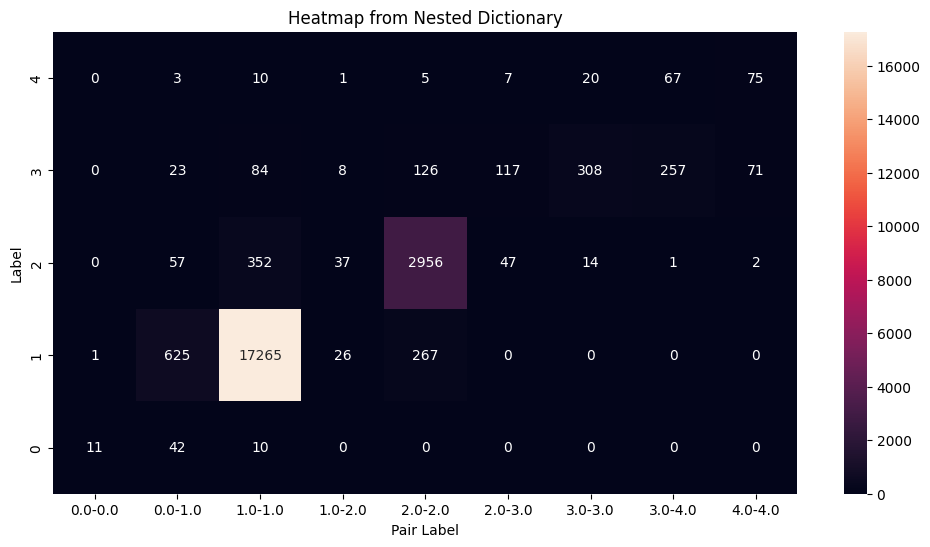

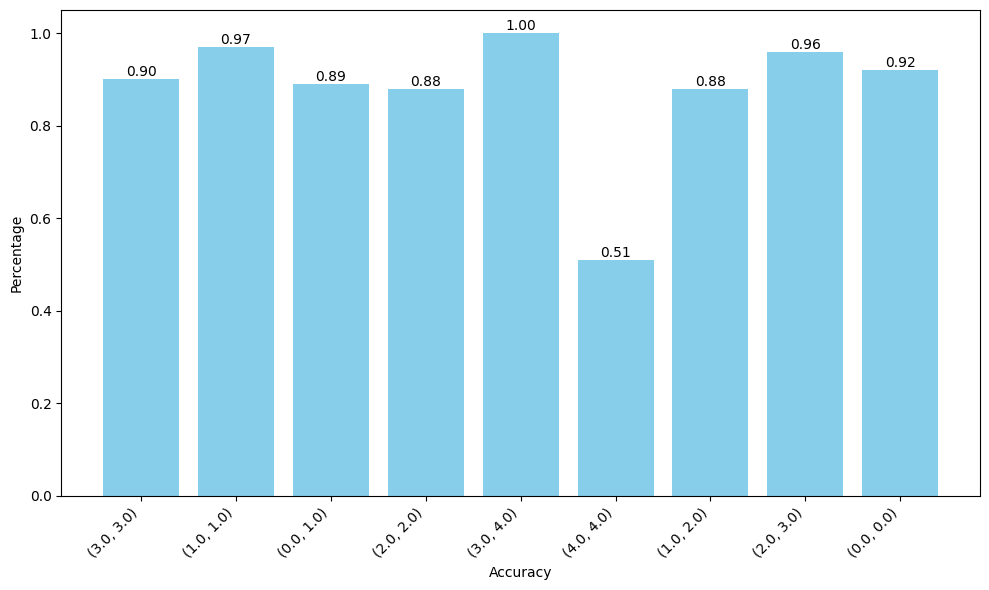

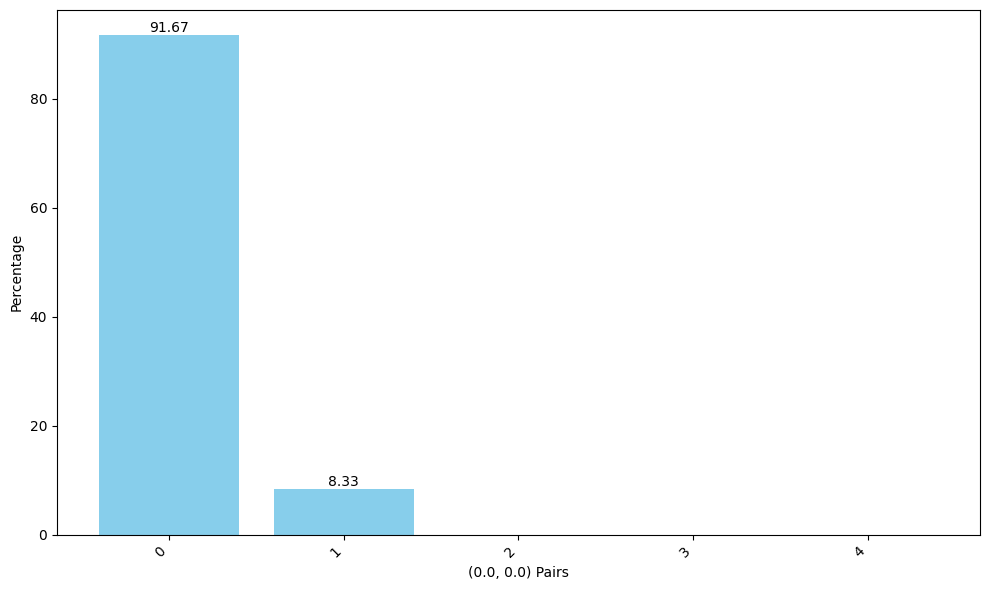

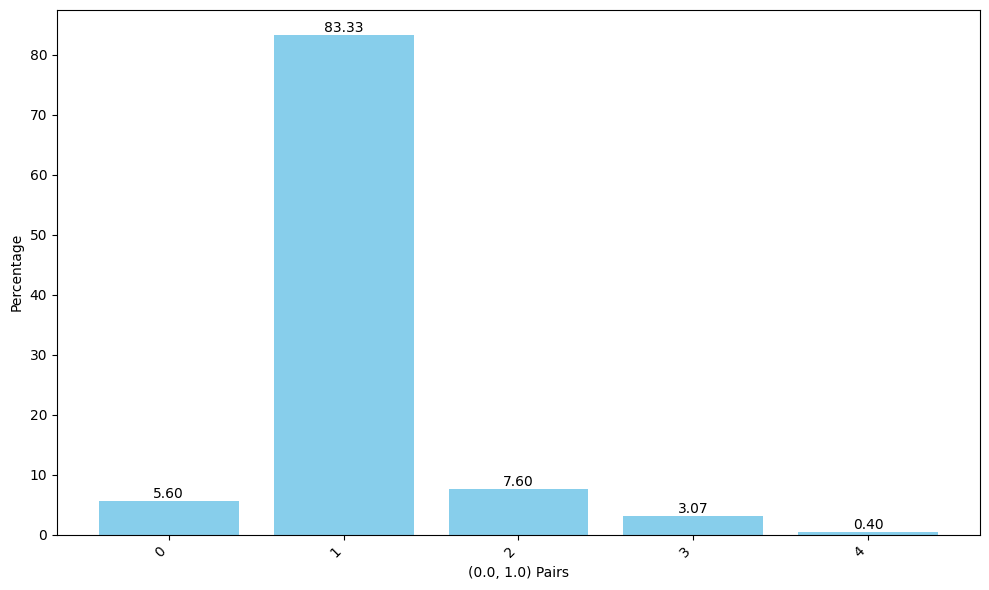

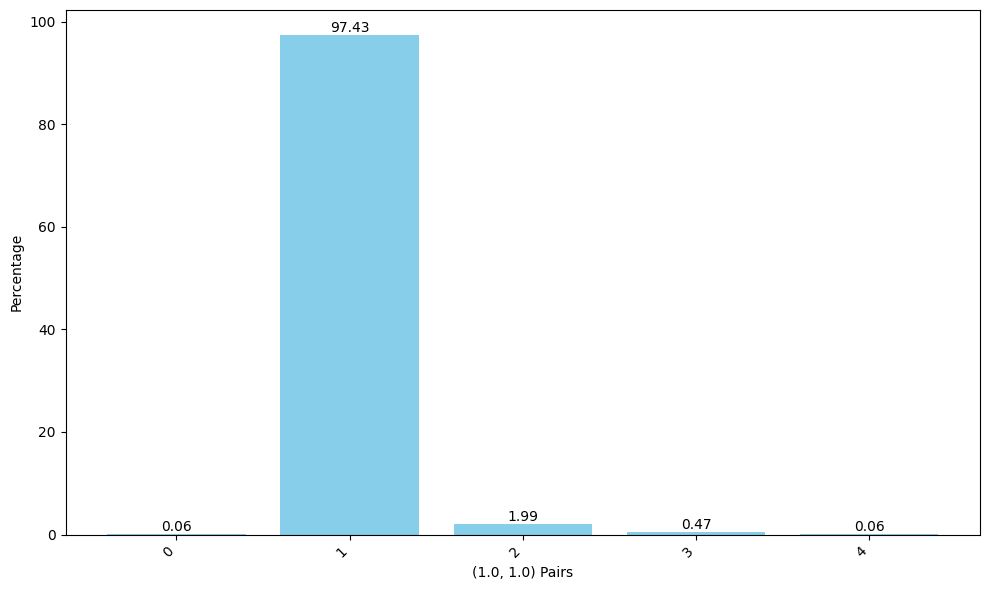

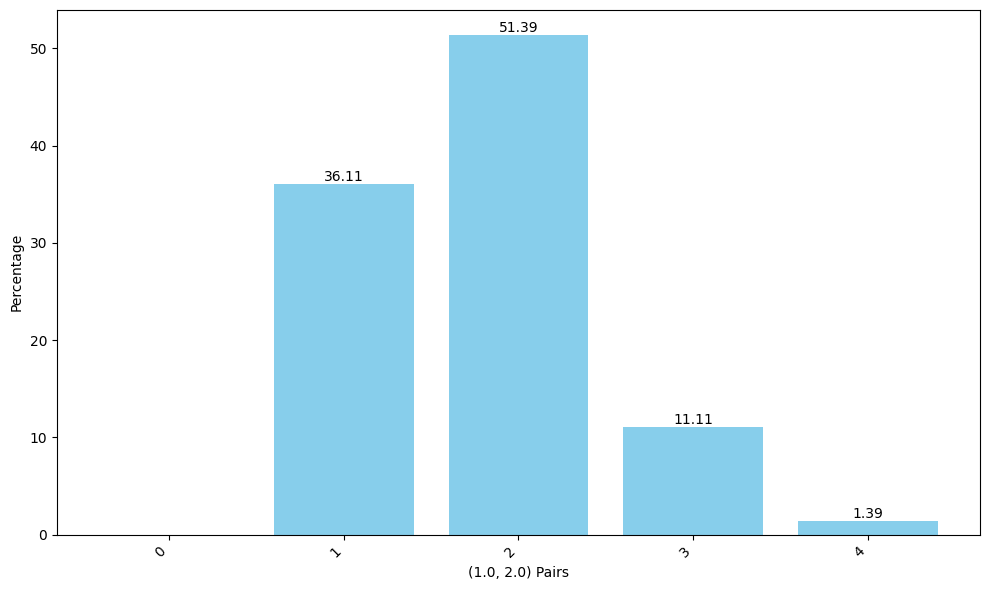

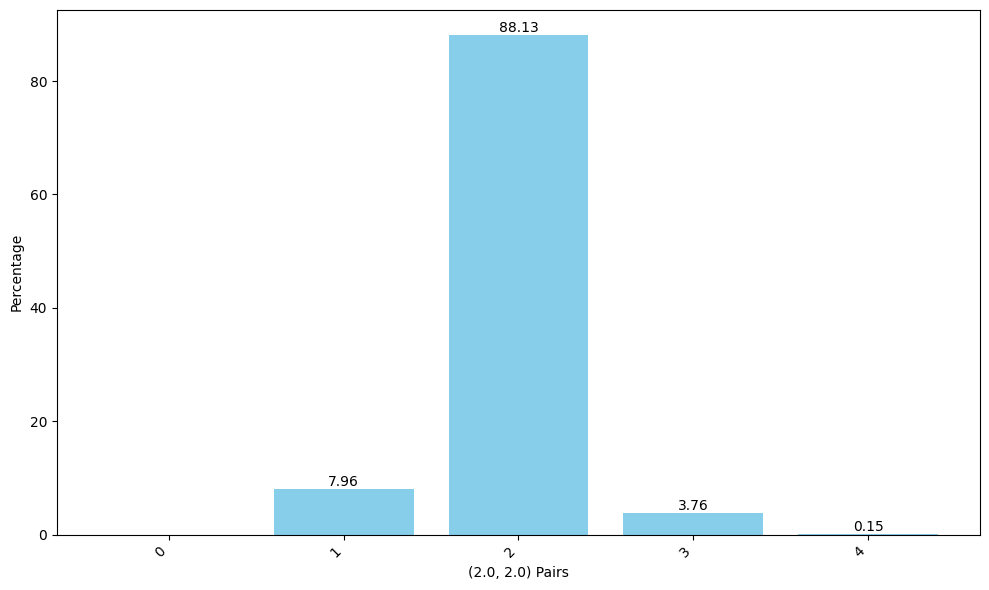

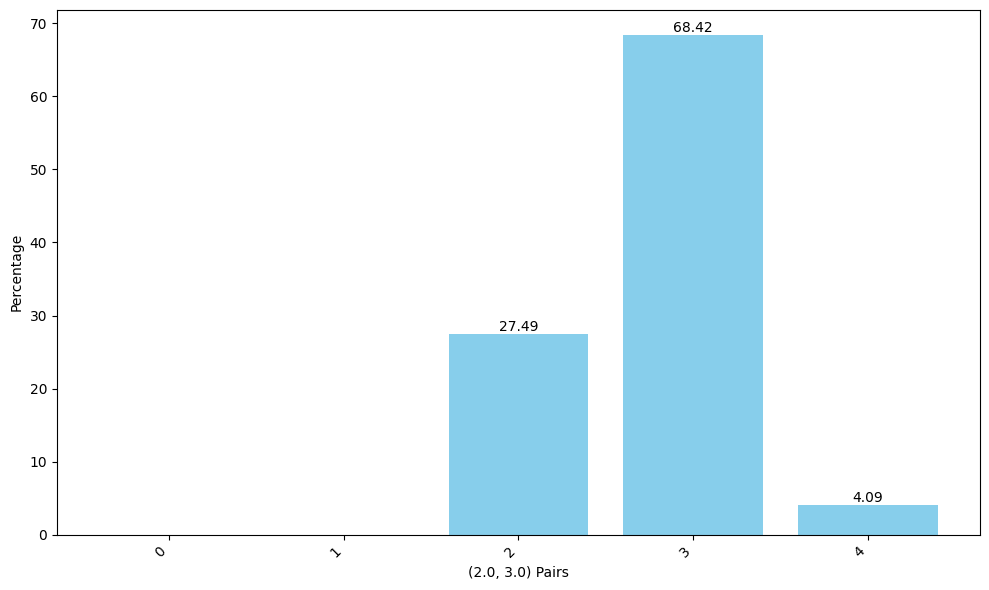

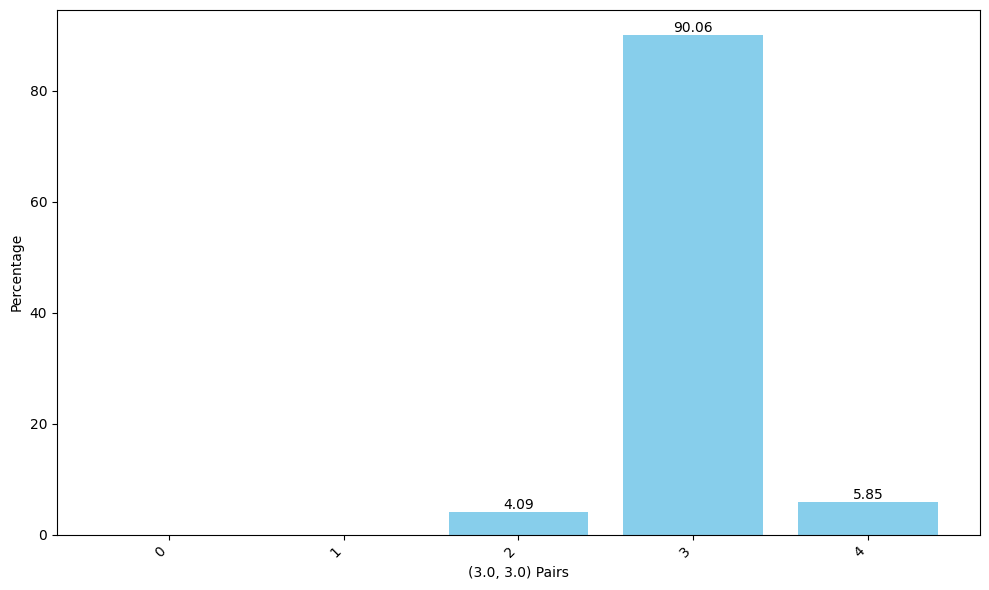

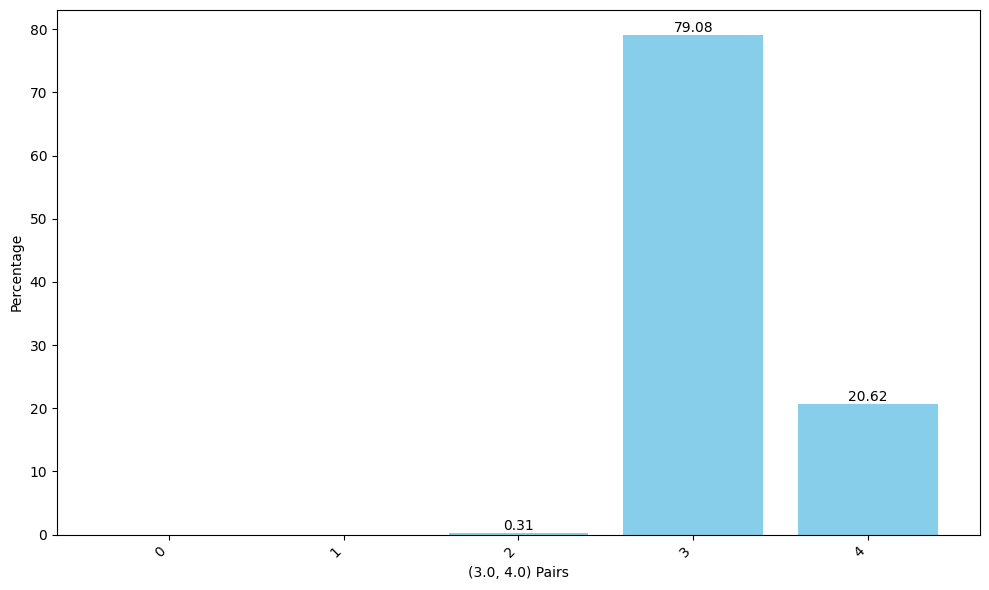

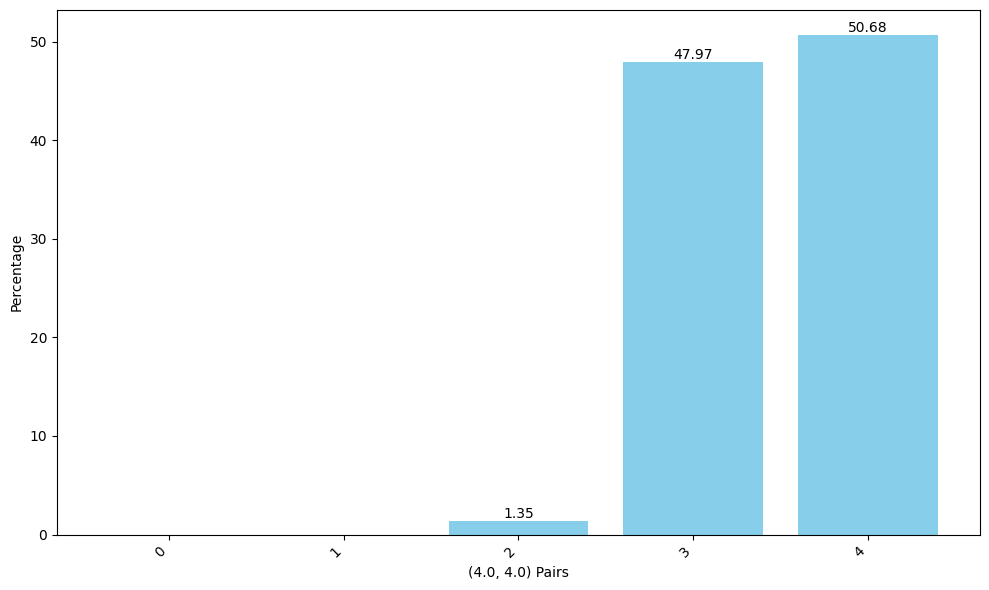

In [9]:
reporting(first_y_test, second_y_test, predicted_labels)


In [10]:
import numpy as np

unique_elements, counts = np.unique(pred, return_counts=True)
    
for element, count in zip(unique_elements, counts):
    print("Phần tử", element, "xuất hiện", count, "lần")


Phần tử 0 xuất hiện 1303 lần
Phần tử 1 xuất hiện 19888 lần
Phần tử 2 xuất hiện 1094 lần
Phần tử 3 xuất hiện 451 lần
Phần tử 4 xuất hiện 159 lần
